# Automating Exploitation 2: Fuzzying

## Alessandro Bruni

## Ethical Hacking course, Mar 16th, 2021

In [ ]:
from IPython.display import HTML
HTML("""<style>
    img[alt=right] { float: right; }
</style>""")

# Housekeeping

- Project presentations
- Course planning:
    + Lecture on web exploitation? What do you need for your project?
    + More exploitation: if you missed it, we have organized an [exploitation workshop last week](https://github.com/hoheinzollern/workshop-cybersikkehed)
- Mini project 1 checking the course curriculum out tomorrow

In [ ]:
HTML("<div style='position: relative; padding-bottom: 56.25%; padding-top: 35px; height: 0; overflow: hidden;'><iframe sandbox='allow-scripts allow-same-origin allow-presentation' allowfullscreen='true' allowtransparency='true' frameborder='0' height='315' src='https://www.mentimeter.com/embed/6cd4e987017d6b85e67220a3f60824dd/ee43c4ec7ca7' style='position: absolute; top: 0; left: 0; width: 100%; height: 100%;' width='420'></iframe></div>")

# Plan for this lecture

- What is fuzzying
- Build your own fuzzer
- American Fuzzy Lop (AFL)

# Intro: What is fuzzying?

Slides courtesy of Brandon Faulk

QA Engineer walks into a bar. Orders a beer. Orders 0 beers. Orders 999999999 beers. Orders a lizard. Orders -1 beers. Orders a sfdeljknesv.

Fuzzying is (almost) like that

# Fuzzying

- Often used for file formats or networking protocols
- Easy to set up
- Almost no compute requirements for simple programs
- Generating/mutating inputs for a program
    + Large set of valid inputs (corpus) mixed together and corrupted
    + Read a specification for a protocol, design something to make valid traffic
- Goal of creating an exceptional condition
    + Program crash
    + Unique errors
    + Hangs

# The fuzz cycle

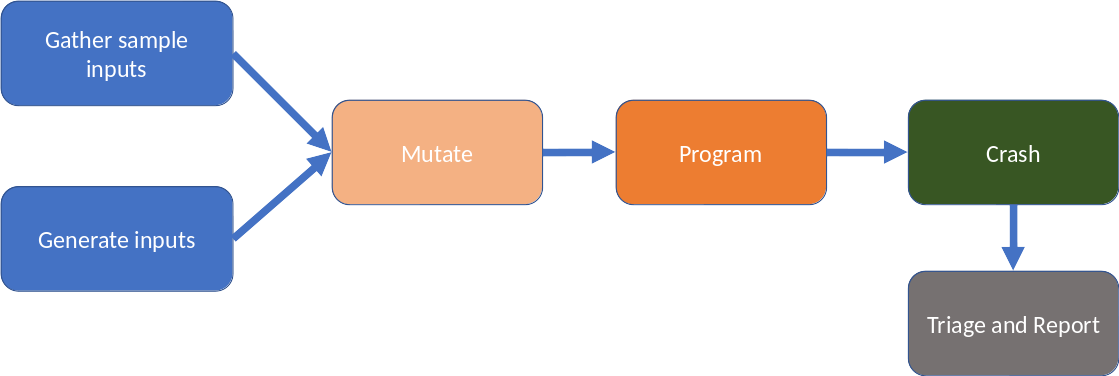

# Limitations of fuzzying

- Generating all valid inputs is nearly impossible
- Custom protocol extensions hard to know about without reversing
- Non-crashing bugs typically not found
   + Arbitrary file read
   + SQL injection
   + Magical privilege escalation
- Hard to interpret progress
   + No crashes? Are there no bugs? Is your fuzzer not working?
   + Loads of crashes? Maybe it’s working? Maybe you’re finding 1% of the bugs?
- Most off the shelf tooling requires source

# Harnessing

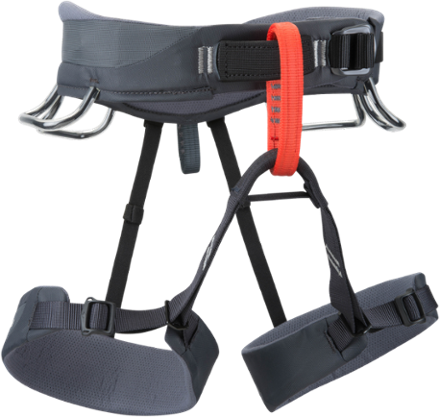
- The tooling used to observe program behavior
   + Debugger watching for crashes
   + Code coverage instrumentation by a compiler
   + Emulators/hypervisors to observe a whole system
- What are they looking for?
   + Crashes
   + Code coverage
   + Unexpected program states
   + Error messages
   + Information leakage



# Examples

(off-the-shelf fuzzers)

# Just invoking the program

- Usually the right place to start
- Write some tool that generates a mutated file
- Run the program to parse the file
- What if we get a crash?
  +  Ehh… just attach GDB or WinDbg or enable core dumps :D
- Reproducibility can be a huge issue
- Can be impossible to scale as the program can only have one instance
- Program startup times can be long (seconds to open up Word)

# AFL

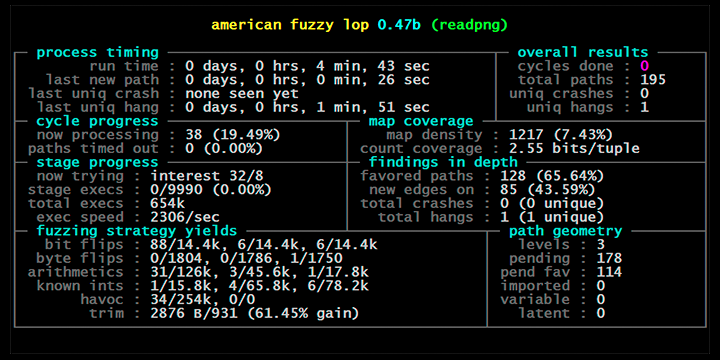

- The gold standard
   +  Looks to be being replaced slowly by libfuzzer in popularity
- Coverage guided
- Relies on having source in standard configuration
- Can use QEMU for coverage

# libfuzzer

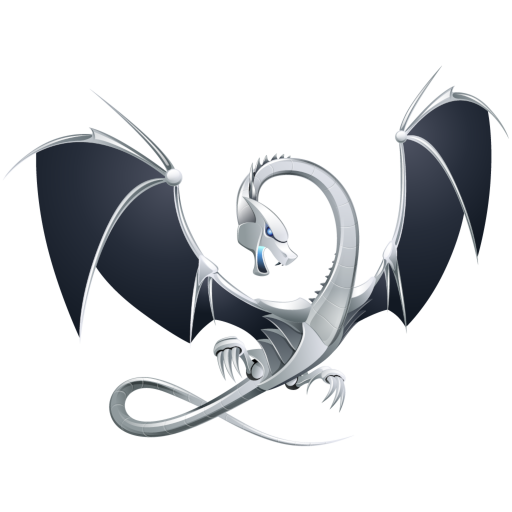
- Designed to be baked into your target application
- Part of LLVM, easily used when building a target with clang
- Coverage guided
- Requires source
- Extremely fast as it’s in-memory fuzzing
  + Not dropping files to disk every iteration
- Similar to AFL it’s corpus based
  + Need to have some well formed inputs to start with

# Architectural Improvements to Fuzzing

# Coverage Guided fuzzying

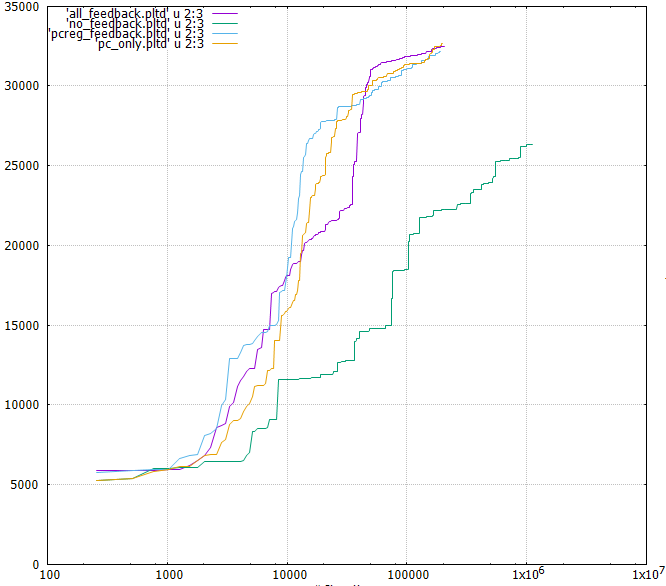
- Gather which code has been hit based on an input
- Input saved when a new unique codepath is observed
- Input is used as a basis for future inputs
- One of the biggest improvements that can be made to a fuzzer
- Can ultimately turn exponential complexity into linear complexity



# Coverage Guided Fuzzing Example

- Write a program to remove all occurrences of the word “the” in a sentence

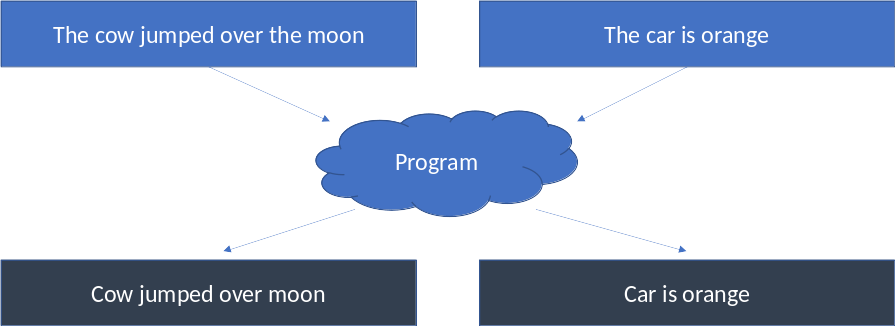

# Coverage Guided Fuzzing Visualized

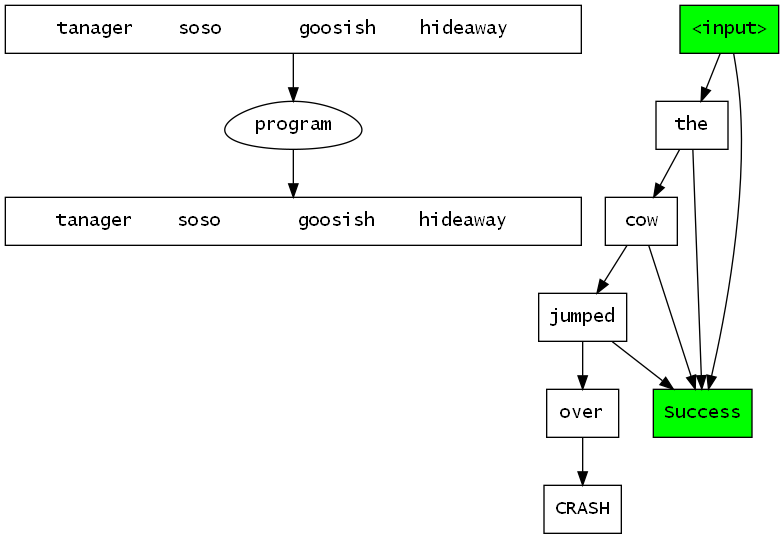

# Coverage Guided Fuzzing Visualized

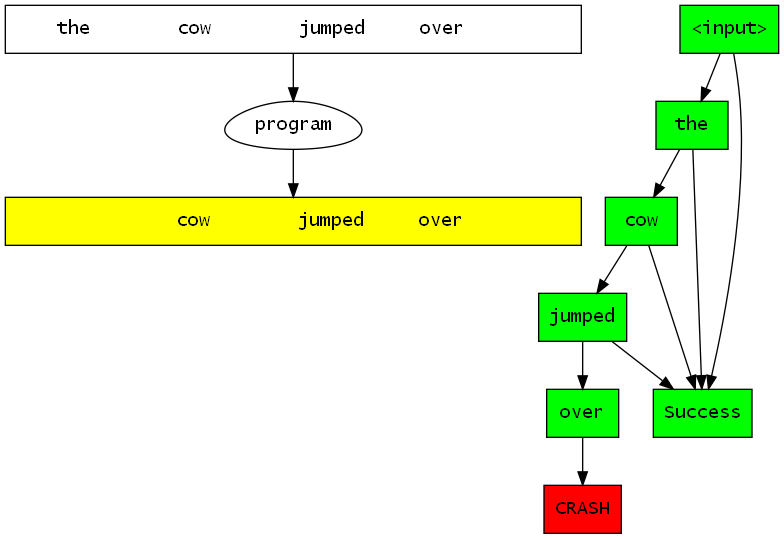

# Feedback Fuzz Cycle

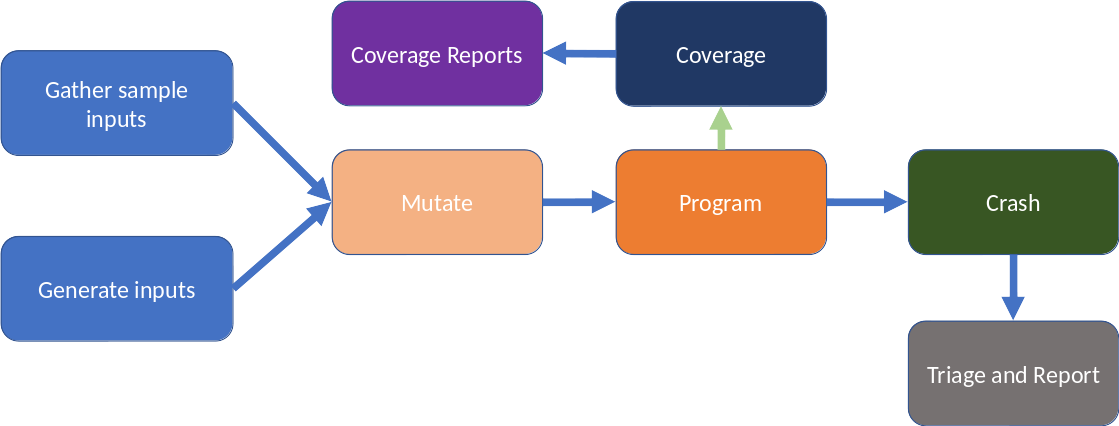

# Crash Amplification

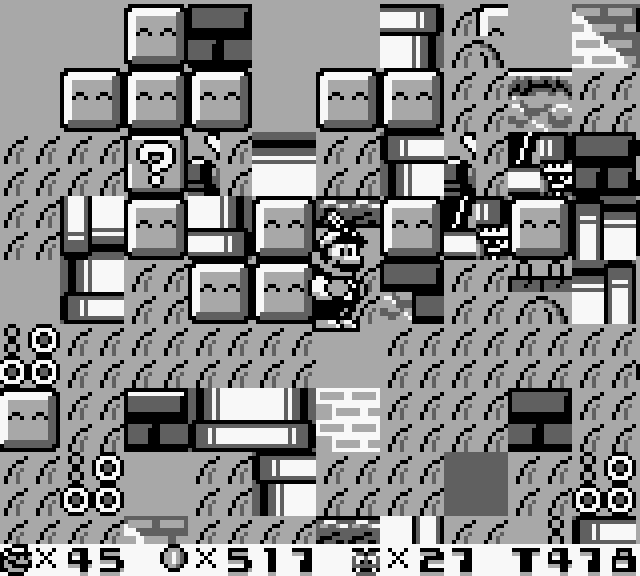
- Increase program sensitivity to malformed input
  + ASAN / PageHeap / Electric Fence
- Heatmaps to direct fuzzying to areas of input that generate more crashes
- Add hooks to find logic bugs (e.g. crash on auth success)
- Limitations:
    + Many programs won't start with ASAN
    + Some incorrect memory access does not result in crashes

# Roll your own fuzzer

Inspired from [fuzzying like a caveman](https://h0mbre.github.io/Fuzzing-Like-A-Caveman/#)

# Scheleton

In [ ]:
import os, sys, random
from pexpect import run
from pipes import quote

def get_bytes(filename):
    f = open(filename, "rb").read()
    return bytearray(f)

def create_new(data):
    f = open("mutated.jpg", "wb+")
    f.write(data)
    f.close()

N = 100000

def exif(counter,data):
    command = "./exif mutated.jpg -verbose"
    out, returncode = run(command, withexitstatus=1)
    if b"ERROR" in out:
        f = open("crashes/crash.{}.jpg".format(str(counter)), "ab+")
        f.write(data)
        f.close()
    if counter % 100 == 0:
        print(counter, end="\r")
    
def fuzz(filename):
    for counter in range(N):
        data = get_bytes(filename)
        mutated = mutate(data)
        create_new(mutated)
        exif(counter,mutated)

# Mutation

In [ ]:
def bit_flip(data):
    num_of_flips = int((len(data) - 4) * .01)
    indexes = range(4, (len(data) - 4))
    chosen_indexes = random.sample(indexes, num_of_flips)
    for x in chosen_indexes:
        data[x] ^= 1 << random.randint(0,7)
    return data

# Gynvael’s Magic Numbers

- Gynvael Coldwind ‘Basics of fuzzing’  enumerates several ‘magic numbers’ that typically produce errors
- These numbers relate to data type sizes and arithmetic-induced errors

```
    0xFF
    0x7F
    0x00
    0xFFFF
    0x0000
    0xFFFFFFFF
    0x00000000
    0x80000000 <- minimum 32-bit int
    0x40000000 <- just half of that amount
    0x7FFFFFFF <- max 32-bit int
```
- If used as parameters to `malloc()` or other array operations, overflows are common
- For instance `0x1` plus `0xFF` on a one-byte register overflows to `0x00` and can produce unintended behavior
- HEVD actually has an integer overflow bug similar to this concept.

- If we choose to use `0x7FFFFFFF` as the magic number then we need to change four bytes

# Magic number mutation

In [ ]:
def magic(data):

    magic_vals = [(1, 255), (1, 255), (1, 127), (1, 0), (2, 255), (2, 0), 
                  (4, 255), (4, 0), (4, 128), (4, 64), (4, 127) ]

    (picked_size, picked_magic) = random.choice(magic_vals)

    picked_index = random.randint(4, len(data)-4)
    
    for i in range(picked_size):
        data[picked_index + i] = picked_magic

    return data

# Mutation - putting it together

In [ ]:
def mutate(data):
    f = random.choice([bit_flip, magic])
    return f(data)

fuzz('input.jpg')

- Input: ![input image](input.jpg)
- Target: https://github.com/mkttanabe/exif
- Compile with ASAN: `-fsanitize=address -ggdb`

# Triaging

In [12]:
import os

def get_files():
    return os.listdir("crashes/")

def triage_files(files):
    for x in files:
        original_output = os.popen("exifsan " + x + " -verbose 2>&1").read()
        output = original_output

        # Getting crash reason
        crash = "SEGV" if "SEGV" in output else "HBO" if "heap-buffer-overflow" in output else None

        if crash == "HBO":
            output = output.split("\n")
            counter = 0
            while counter < len(output):
                if output[counter] == "=================================================================":
                    target_line = output[counter + 1]
                    target_line2 = output[counter + 2]
                    counter += 1
                else:
                    counter += 1
            target_line = target_line.split(" ")
            address = target_line[5].replace("0x","")


            target_line2 = target_line2.split(" ")
            operation = target_line2[0]


        elif crash == "SEGV":
            output = output.split("\n")
            counter = 0
            while counter < len(output):
                if output[counter] == "=================================================================":
                    target_line = output[counter + 1]
                    target_line2 = output[counter + 2]
                    counter += 1
                else:
                    counter += 1
            if "unknown address" in target_line:
                address = "00000000"
            else:
                address = None

            if "READ" in target_line2:
                operation = "READ"
            elif "WRITE" in target_line2:
                operation = "WRITE"
            else:
                operation = None

        if crash:
            log_name = (x.replace(".jpg","") + "." + crash + "." + address + "." + operation)
            f = open(log_name,"w+")
            f.write(original_output)
            f.close()
files = get_files()
triage_files(files)

# Trying AFL